**Library Installation: **
These commands install necessary libraries: ftfy, regex, tqdm, the CLIP library from OpenAI's GitHub, torchvision for datasets, and pycocotools for the COCO dataset.

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torchvision
!pip install pycocotools

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ut_aq68m
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ut_aq68m
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


**Import Libraries**

In [ ]:
import numpy as np
import torch
import clip
from torchvision.datasets import CocoCaptions
from PIL import Image
import matplotlib.pyplot as plt
import os

**Load CLIP Model: **
Loads the CLIP model and preprocessing pipeline and moves the model to GPU (if available).

In [ ]:
print("Torch version:", torch.__version__)

Torch version: 2.4.1+cu121


In [ ]:
model, preprocess = clip.load("RN50x64")
model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)


**Prepare Dataset Paths**

Sets the path for storing the COCO dataset.

In [ ]:
coco_root = os.path.expanduser("~/.cache/coco")
os.makedirs(coco_root, exist_ok=True)

**Download and Unzip COCO Data**

In [ ]:
import os

# Define the path where the COCO dataset will be stored
coco_root = os.path.expanduser("~/.cache/coco")
train2017_path = os.path.join(coco_root, 'train2017.zip')
unzip_dir = os.path.join(coco_root, 'train2017')

# Create the directory if it does not exist
os.makedirs(coco_root, exist_ok=True)

# Check if the zip file already exists
if not os.path.exists(train2017_path):
    print("Downloading train2017.zip...")
    !wget http://images.cocodataset.org/zips/train2017.zip -P {coco_root}
else:
    print("train2017.zip already exists. Skipping download.")

# Check if the directory already exists to avoid unzipping again
if not os.path.exists(unzip_dir):
    print("Unzipping train2017.zip...")
    !unzip {train2017_path} -d {coco_root}
else:
    print("train2017 directory already exists. Skipping unzipping.")

# Optional: Remove the zip file after unzipping
if os.path.exists(train2017_path):
    os.remove(train2017_path)
    print("Removed train2017.zip after unzipping.")




--2024-10-08 12:11:21--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.203.105, 3.5.30.110, 3.5.22.12, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.203.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘/root/.cache/coco/train2017.zip’

train2017.zip       100%[===================>]  18.01G  15.1MB/s    in 18m 37s 

2024-10-08 12:29:59 (16.5 MB/s) - ‘/root/.cache/coco/train2017.zip’ saved [19336861798/19336861798]

train2017 directory already exists. Skipping unzipping.
Removed train2017.zip after unzipping.


**Model Details**

Prints the model's input resolution, context length, vocabulary size, and total number of parameters.

In [ ]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [ ]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 623,258,305
Input resolution: 448
Context length: 77
Vocab size: 49408


**Download Annotations**

In [ ]:
annotations_path = os.path.join(coco_root, 'annotations_trainval2017.zip')
if not os.path.exists(annotations_path):
    print("Downloading annotations_trainval2017.zip...")
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {coco_root}
else:
    print("annotations_trainval2017.zip already exists. Skipping download.")


annotations_trainval2017.zip already exists. Skipping download.


In [ ]:
!ls {coco_root}


annotations		      annotations_trainval2017.zip.1  train2017
annotations_trainval2017.zip  annotations_trainval2017.zip.2  train2017.zip


In [ ]:
annotations_dir = os.path.join(coco_root, 'annotations')
os.makedirs(annotations_dir, exist_ok=True)

!unzip -o {annotations_path} -d {annotations_dir}

Archive:  /root/.cache/coco/annotations_trainval2017.zip
  inflating: /root/.cache/coco/annotations/annotations/instances_train2017.json  
  inflating: /root/.cache/coco/annotations/annotations/instances_val2017.json  
  inflating: /root/.cache/coco/annotations/annotations/captions_train2017.json  
  inflating: /root/.cache/coco/annotations/annotations/captions_val2017.json  
  inflating: /root/.cache/coco/annotations/annotations/person_keypoints_train2017.json  
  inflating: /root/.cache/coco/annotations/annotations/person_keypoints_val2017.json  


**Load COCO Dataset**

Loads the COCO dataset with captions and applies preprocessing.


In [ ]:
# Update the path to the annotations file
ann_file = os.path.join(annotations_dir, 'annotations', 'captions_train2017.json')

# Define the root directory for the COCO images
root_dir = unzip_dir  # Set this to where the train2017 images are located

# Load the COCO dataset
coco_dataset = CocoCaptions(root=root_dir, annFile=ann_file, transform=preprocess)

# Check the dataset length to confirm loading
print(f"Number of images in the dataset: {len(coco_dataset)}")

loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
Number of images in the dataset: 118287


**Visualize Dataset**

Visualizes sample images and captions from the COCO dataset.

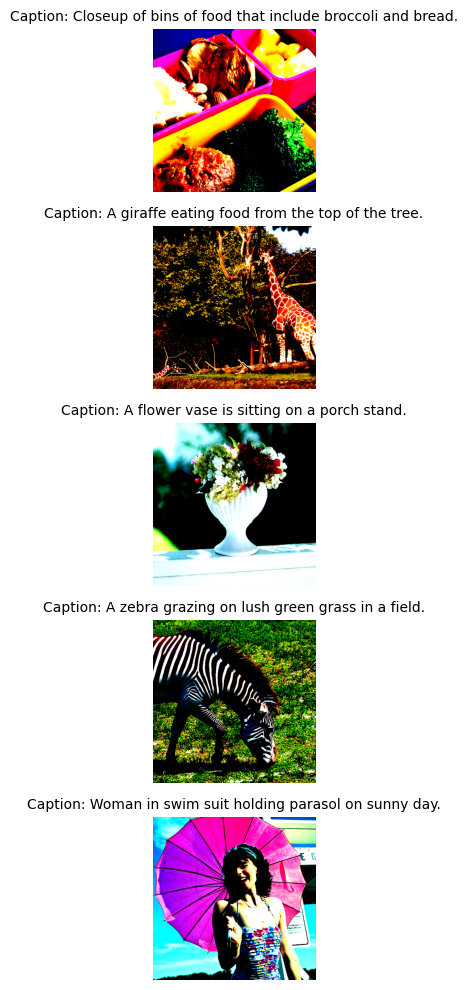

In [ ]:
import matplotlib.pyplot as plt

# Set number of samples to display
num_samples = 5  # Change this to display more or fewer samples

# Set up the figure
plt.figure(figsize=(15, 10))  # Adjust height for better layout

for i in range(num_samples):
    image, caption = coco_dataset[i]

    # Convert the image to a NumPy array and rearrange dimensions
    image_np = np.array(image)  # Convert PIL Image to NumPy array
    if image_np.ndim == 3:  # Ensure it has the correct number of dimensions
        image_np = image_np.transpose(1, 2, 0)  # Rearrange to H x W x C

    plt.subplot(num_samples, 1, i + 1)  # Create a subplot for each image in a column
    plt.imshow(image_np)
    plt.axis("off")  # Hide axes for clarity

    # Add caption below the image
    plt.title(f"Caption: {caption[0]}", fontsize=10)  # Display the first caption (there may be multiple)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


**Process and Encode Data**

Processes and encodes images and captions into feature vectors and calculates similarity scores.

In [ ]:
# Number of samples to visualize
num_samples = 5  # Adjust this number as needed

# Initialize lists to hold the images and captions
images = []
captions = []

for i in range(num_samples):
    # Get image and caption from the dataset
    image, caption = coco_dataset[i]

    # Check if image is a tensor
    if isinstance(image, torch.Tensor):
        images.append(image)  # Directly append the tensor
    else:
        print(f"Image at index {i} is not a tensor but a {type(image)}")

    captions.append(caption[0])  # Take the first caption if there are multiple

# Convert lists to tensors
images_tensor = torch.stack(images).cuda()  # Move to GPU if available
text_tokens = clip.tokenize(captions).cuda()

print(f"Number of images: {len(images_tensor)}")
print(f"Number of captions: {len(captions)}")


Number of images: 5
Number of captions: 5


In [ ]:
# Encode images and captions
with torch.no_grad():  # Disable gradient calculation for inference
    image_features = model.encode_image(images_tensor)
    text_features = model.encode_text(text_tokens)

# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Print the shapes of the features
print(f"Image features shape: {image_features.shape}")
print(f"Text features shape: {text_features.shape}")


Image features shape: torch.Size([5, 1024])
Text features shape: torch.Size([5, 1024])


**Visualize Similarity Scores**

Visualizes similarity scores between images and captions using subplots.

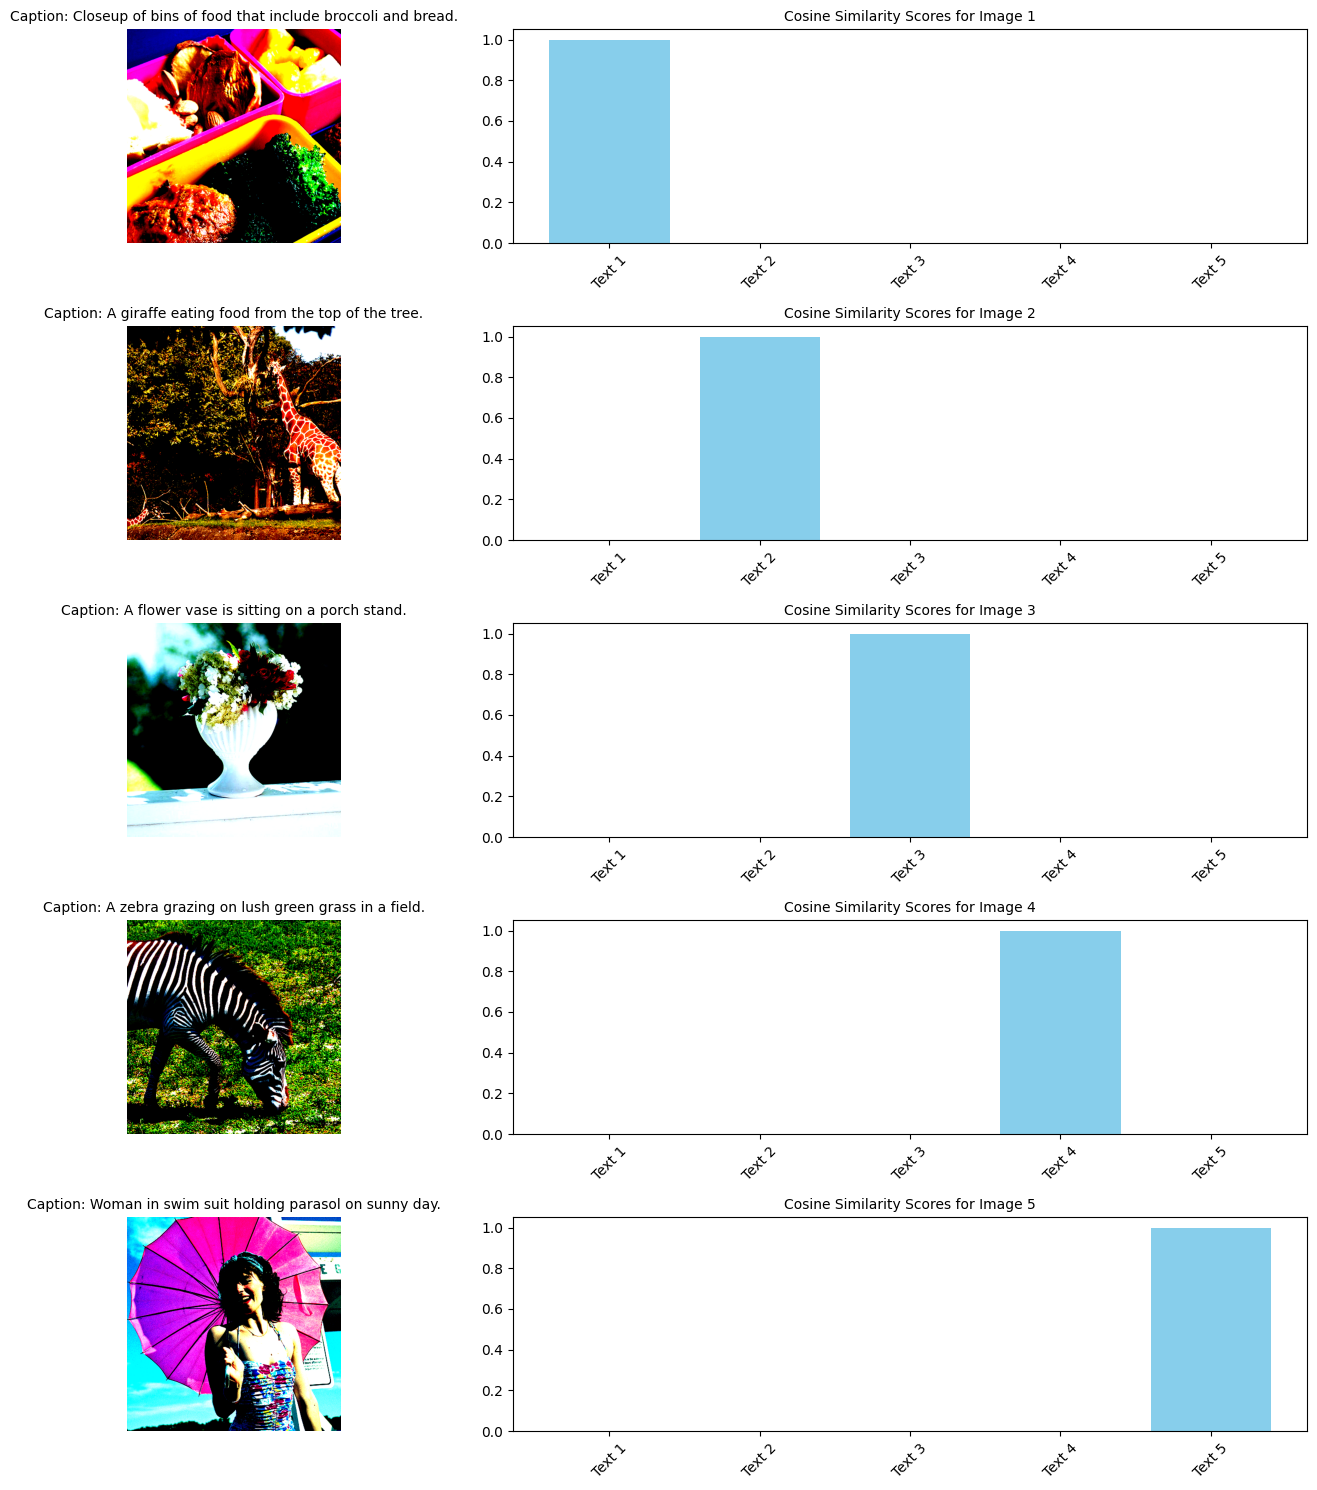

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set number of samples to display
num_samples = 5  # Change this to display more or fewer samples

# Calculate cosine similarity
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# Set up the figure
fig, axs = plt.subplots(num_samples, 2, figsize=(15, 3 * num_samples))  # Create subplots for images and similarity scores

for i in range(num_samples):
    image, caption = coco_dataset[i]

    # Convert the image to a NumPy array and rearrange dimensions
    image_np = np.array(image)  # Convert PIL Image to NumPy array
    if image_np.ndim == 3:  # Ensure it has the correct number of dimensions
        image_np = image_np.transpose(1, 2, 0)  # Rearrange to H x W x C

    # Display the image
    axs[i, 0].imshow(image_np)
    axs[i, 0].axis("off")  # Hide axes
    axs[i, 0].set_title(f"Caption: {caption[0]}", fontsize=10)  # Display the first caption

    # Plot cosine similarity for the current image
    similarity_scores = similarity[i].detach().cpu().numpy()  # Get similarity scores for the current image
    axs[i, 1].bar(range(len(similarity_scores)), similarity_scores, color='skyblue')  # Create a bar chart
    axs[i, 1].set_title(f"Cosine Similarity Scores for Image {i + 1}", fontsize=10)
    axs[i, 1].set_xticks(range(len(similarity_scores)))  # Set x-ticks
    axs[i, 1].set_xticklabels([f"Text {j + 1}" for j in range(len(similarity_scores))], rotation=45)  # Label x-ticks

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


**Display and Print Top Matches**

Displays images with captions and prints top matches based on similarity scores.

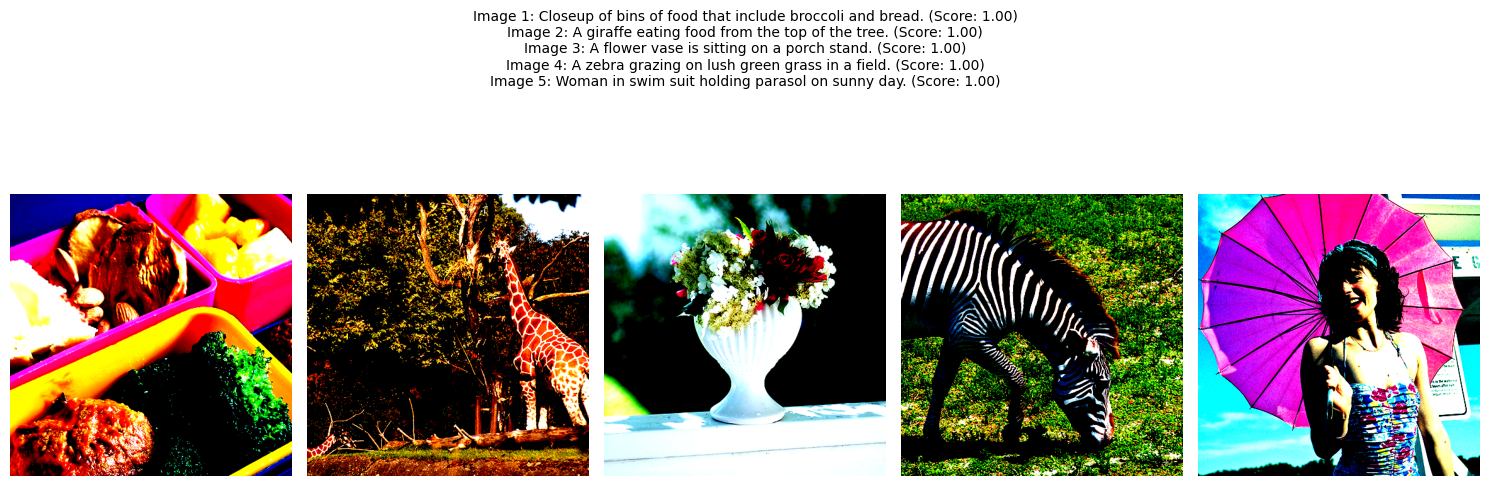

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure with a specific size
plt.figure(figsize=(15, 6))  # Adjust height to fit both image and caption

num_samples = len(images_tensor)  # Ensure num_samples is correctly set

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)

    # Convert tensor to numpy for display
    plt.imshow(images_tensor[i].permute(1, 2, 0).cpu())  # Permute to (H, W, C)

    # Hide axes
    plt.axis("off")

# Create a separate title for captions below the images
plt.suptitle("\n".join([f"Image {i+1}: {captions[i]} (Score: {similarity[i].max():.2f})" for i in range(num_samples)]), fontsize=10, ha='center')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.subplots_adjust(top=0.85)  # Adjust top spacing for title
plt.show()


In [ ]:
k = 3  # Number of top matches to retrieve
top_k_indices = similarity.topk(k, dim=-1).indices

for i in range(num_samples):
    print(f"Image {i}:")
    for j in range(k):
        caption_index = top_k_indices[i, j]
        print(f"  Top {j + 1}: {captions[caption_index]} (Score: {similarity[i, caption_index]:.2f})")


Image 0:
  Top 1: Closeup of bins of food that include broccoli and bread. (Score: 1.00)
  Top 2: A giraffe eating food from the top of the tree. (Score: 0.00)
  Top 3: A flower vase is sitting on a porch stand. (Score: 0.00)
Image 1:
  Top 1: A giraffe eating food from the top of the tree. (Score: 1.00)
  Top 2: A zebra grazing on lush green grass in a field. (Score: 0.00)
  Top 3: Woman in swim suit holding parasol on sunny day. (Score: 0.00)
Image 2:
  Top 1: A flower vase is sitting on a porch stand. (Score: 1.00)
  Top 2: A zebra grazing on lush green grass in a field. (Score: 0.00)
  Top 3: Closeup of bins of food that include broccoli and bread. (Score: 0.00)
Image 3:
  Top 1: A zebra grazing on lush green grass in a field. (Score: 1.00)
  Top 2: A giraffe eating food from the top of the tree. (Score: 0.00)
  Top 3: Closeup of bins of food that include broccoli and bread. (Score: 0.00)
Image 4:
  Top 1: Woman in swim suit holding parasol on sunny day. (Score: 1.00)
  Top 2: A fl